<a href="https://colab.research.google.com/github/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/2_8_singular_value_decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Singular Value Decomposition

Since the beginning of this series, I emphasized the fact that you can see matrices as linear transformation in space. With the SVD, you decompose a matrix in three other matrices. You can see these new matrices as *sub-transformations* of the space. Instead of doing the transformation in one movement, we decompose it in three movements. 

As a bonus, we will apply the SVD to image processing. We will see the effect of SVD on an image of Lucy the goose (it is just a goose named Lucy...) so keep on reading!


<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/unit-circle-transformation1.png?raw=1" width="400" alt="Plot of the unit circle and its transformation" title="Transformation of the unit circle">

<em>The unit circle and its transformation by a matrix.</em>

We saw in [2.7](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.7-Eigendecomposition/) that the eigendecomposition can be done only for square matrices. The way to go to decompose other types of matrices that can't be decomposed with eigendecomposition is to use **Singular Value Decomposition** (SVD).

We will decompose ${A}$ into 3 matrices (instead of two with eigendecomposition):

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/singular-value-decomposition.png?raw=1" width="300" alt="Illustration of the singular value decomposition" title="The singular value decomposition">

<em>The singular value decomposition</em>

The matrices ${U}$, ${D}$, and ${V}$ have the following properties:

- ${U}$ and ${V}$ are orthogonal matrices (${U}^\text{T}={U}^{-1}$ and ${V}^\text{T}={V}^{-1}$; see [2.6](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.6-Special-Kinds-of-Matrices-and-Vectors/) for more details about orthogonal matrices)

- ${D}$ is a diagonal matrix (all 0 except the diagonal ; see [2.6](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.6-Special-Kinds-of-Matrices-and-Vectors/)). However ${D}$ is not necessarily square.

The columns of ${U}$ are called the left-singular vectors of ${A}$ while the columns of ${V}$ are the right-singular vectors of ${A}$. The values along the diagonal of ${D}$ are the singular values of ${A}$.

Here are the dimensions of the factorization:

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/singular-value-decomposition-understanding-dimensions.png?raw=1" width="300" alt="Dimensions of the singular value decomposition (SVD)" title="The dimensions of the singular value decomposition (SVD)">

<em>The dimensions of the singular value decomposition</em>


The diagonal matrix of singular values is not square but have the shape of ${A}$. Look at the example provided in the [Numpy doc](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) to see that they create a matrix of zeros with the same shape as ${A}$ and fill it with the singular values:

```python
smat = np.zeros((9, 6), dtype=complex)
smat[:6, :6] = np.diag(s)
```

##Setup

In [1]:
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Plot parameters
sns.set()
%pylab inline
pylab.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['ytick.major.size'] = 0
# Avoid inaccurate floating values (for inverse matrices in dot product for instance)
# See https://stackoverflow.com/questions/24537791/numpy-matrix-inversion-rounding-errors
np.set_printoptions(suppress=True)

In [3]:
def plot_vectors(vecs, cols, alpha=1):
  plt.axvline(x=0, color='#A9A9A9', zorder=0)
  plt.axhline(y=0, color='#A9A9A9', zorder=0)

  for i in range(len(vecs)):
    if (isinstance(alpha, list)):
        alpha_i = alpha[i]
    else:
        alpha_i = alpha
    x = np.concatenate([[0,0],vecs[i]])
    plt.quiver([x[0]],
                [x[1]],
                [x[2]],
                [x[3]],
                angles='xy', scale_units='xy', scale=1, color=cols[i],
                alpha=alpha)

Let's create a function that takes a 2D matrix as an input and draw the unit circle transformation when we apply this matrix to it.

In [4]:
def plot_matrix(matrix, vectorsCol=['#FF9A13', '#1190FF']):
  """
  Modify the unit circle and basis vector by applying a matrix.
  Visualize the effect of the matrix in 2D.

  Parameters
  ----------
  matrix : array-like
      2D matrix to apply to the unit circle.
  vectorsCol : HEX color code
      Color of the basis vectors

  Returns:

  fig : instance of matplotlib.figure.Figure
      The figure containing modified unit circle and basis vectors.
  """
  # Unit circle
  x = np.linspace(-1, 1, 100000)
  y = np.sqrt(1-(x**2))
  
  # Modified unit circle (separate negative and positive parts)
  x1 = matrix[0,0]*x + matrix[0,1]*y
  y1 = matrix[1,0]*x + matrix[1,1]*y
  x1_neg = matrix[0,0]*x - matrix[0,1]*y
  y1_neg = matrix[1,0]*x - matrix[1,1]*y
  
  # Vectors
  u1 = [matrix[0,0],matrix[1,0]]
  v1 = [matrix[0,1],matrix[1,1]]
  
  plot_vectors([u1, v1], cols=[vectorsCol[0], vectorsCol[1]])

  plt.plot(x1, y1, 'g', alpha=0.5)
  plt.plot(x1_neg, y1_neg, 'g', alpha=0.5)

In [ ]:
!wget https://github.com/hadrienj/deepLearningBook-Notes/raw/master/2.8%20Singular%20Value%20Decomposition/test_svd.jpg

## Intuition

I think that the intuition behind the singular value decomposition needs some explanations about the idea of matrix transformation. For that reason, here are several examples showing how the space can be transformed by 2D square matrices. 

Hopefully, this will lead to a better understanding of this statement: ${A}$ is a matrix that can be seen as a linear transformation. 

This transformation can be decomposed in three sub-transformations: 

1. rotation, 
2. re-scaling, 
3. rotation.

These three steps correspond to the three matrices ${U}$, ${D}$, and ${V}$.

You can look at [this animation](https://en.wikipedia.org/wiki/Singular-value_decomposition) from the Wikipedia article on the SVD. If you scroll down the page you will see each step.

**Every matrix can be seen as a linear transformation**

You can see a matrix as a specific linear transformation. When you *apply* this matrix to a vector or to another matrix you will apply this linear transformation to it.


### Example 1: Vector scaling

We will modify the vector:

$$
{v}=\begin{bmatrix}
    x\\\\
    y
\end{bmatrix}
$$

by applying the matrix:

$$
\begin{bmatrix}
    2 & 0\\\\
    0 & 2
\end{bmatrix}
$$

We will have:

$$
\begin{bmatrix}
    x'\\\\
    y'
\end{bmatrix}=\begin{bmatrix}
    2 & 0\\\\
    0 & 2
\end{bmatrix}
\begin{bmatrix}
    x\\\\
    y
\end{bmatrix}=
\begin{bmatrix}
    2x + 0y\\\\
    0x + 2y
\end{bmatrix}=
\begin{bmatrix}
    2x\\\\
    2y
\end{bmatrix}
$$

We see that applying the matrix:

$$
\begin{bmatrix}
    2 & 0\\\\
    0 & 2
\end{bmatrix}
$$

just doubled each coordinate of our vector. Here are the graphical representation of ${v}$ and its transformation ${w}$:

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/transformation-vector-by-matrix.png?raw=1" width="400" alt="Plot of a vector and its transformation" title="The matrix increased both coordinates of the vector">

<em>Applying the matrix on the vector multiplied each coordinate by two</em>

You can look at other examples of simple transformations on vectors and unit circle in [this video](https://www.youtube.com/watch?v=kJIUbtSowRg).

In [6]:
v = np.array([1, 1])

A = np.array([
   [2, 0],
   [0, 2]           
])

W = np.matmul(A, v)
W

array([2, 2])

### Example 2: Unit circle scaling

To represent the linear transformation associated with matrices we can also draw the unit circle and see how a matrix can transform it (see the BONUS in [2.7](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.7-Eigendecomposition/)). The unit circle represents the coordinates of every unit vectors (vector of length 1, see [2.6](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.6-Special-Kinds-of-Matrices-and-Vectors/)).

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/unit-circle.png?raw=1" width="200" alt="Representation of the unit circle" title="The unit circle">

<em>The unit circle</em>

It is then possible to apply a matrix to all these unit vectors to see the kind of deformation it will produce.

Again, let's apply the matrix:

$$
\begin{bmatrix}
    2 & 0\\\\
    0 & 2
\end{bmatrix}
$$

to the unit circle:

$$
\begin{bmatrix}
    x'\\\\
    y'
\end{bmatrix}=
\begin{bmatrix}
    2 & 0\\\\
    0 & 2
\end{bmatrix}
\begin{bmatrix}
    x\\\\
    y
\end{bmatrix}=
\begin{bmatrix}
    2x\\\\
    2y
\end{bmatrix}
$$

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/unit-circle-transformation.png?raw=1" width="400" alt="Representation of the unit circle and its transformation" title="The unit circle and its transformation">

<em>Another representation of the effect of the matrix: each coordinate of the unit circle was multiplied by two</em>

We can see that the matrix doubled the size of the circle. But in some transformations, the change applied to the $x$ coordinate is different from the change applied to the $y$ coordinate. 

Let's see what it means graphically.

### Example 3: Diagonal matrix

We will apply the matrix:

$$
\begin{bmatrix}
    3 & 0\\\\
    0 & 2
\end{bmatrix}
$$

to the unit circle:

$$
\begin{bmatrix}
    x'\\\\
    y'
\end{bmatrix}=
\begin{bmatrix}
    3 & 0\\\\
    0 & 2
\end{bmatrix}\cdot
\begin{bmatrix}
    x\\\\
    y
\end{bmatrix}=
\begin{bmatrix}
    3x\\\\
    2y
\end{bmatrix}
$$

This gives the following new circle:

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/unit-circle-transformation1.png?raw=1" width="400" alt="Representation of the unit circle and its transformation" title="The unit circle and its transformation">

<em>This time the matrix didn't rescale each coordinate with the same weight</em>

We can check that with the equations associated with this matrix transformation. Let's say that the coordinates of the new circle (after transformation) are $x'$ and $y'$. The relation between the old coordinates ($x$, $y$) and the new coordinates ($x'$, $y'$) is:

$$
\begin{bmatrix}
    x'\\\\
    y'
\end{bmatrix}=
\begin{bmatrix}
    3x\\\\
    2y
\end{bmatrix}
\Leftrightarrow
\begin{cases}
x=\frac{x'}{3}\\\\
y=\frac{y'}{2}
\end{cases}
$$

We also know that the equation of the unit circle is $x^2+y^2=1$ (the norm of the unit vectors is 1, see [2.5](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.5-Norms/)). 

By replacement we end up with:

$$
\begin{align*}
\left(\frac{x'}{3}\right)^2 + \left(\frac{y'}{2}\right)^2 = 1\\\\
\left(\frac{y'}{2}\right)^2 = 1 - \left(\frac{x'}{3}\right)^2\\\\
\frac{y'}{2} = \sqrt{1 - \left(\frac{x'}{3}\right)^2}\\\\
y' = 2\sqrt{1 - \left(\frac{x'}{3}\right)^2}
\end{align*}
$$

We can check that this equation corresponds to our transformed circle. 

Let's start by drawing the old circle. Its equation is:

$$
\begin{align*}
x^2+y^2=1\\\\
y^2=1-x^2\\\\
y=\sqrt{1-x^2}
\end{align*}
$$

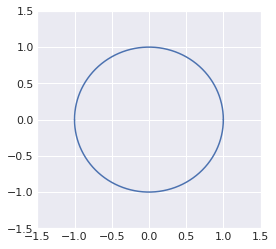

In [7]:
x = np.linspace(-1, 1, 100000)
y = np.sqrt(1 - (x ** 2))

plt.plot(x, y, sns.color_palette().as_hex()[0])
plt.plot(x, -y, sns.color_palette().as_hex()[0])
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

So far so good!

*Coding tip*: You can see the trick to plot a circle here: you create the $x$ variable, then $y$ is defined from $x$. This means that for each $x$, the corresponding $y$ value is calculated (and thus $y$ has the same shape as $x$). Since the result of the square root can be negative or positive (for instance, 4 can be the result of $2^2$ but also of $(-2)^2$) we need to plot both solutions ($y$ and $-y$ in `plt.plot`). Note also that a lot of values are needed if we want the connection between the two demi-spheres. See also some discussion [here](https://stackoverflow.com/questions/32092899/plot-equation-showing-a-circle).


Now let's add the circle obtained after matrix transformation. We saw that it is defined with

$$
y = 2\sqrt{1 - \left(\frac{x}{3}\right)^2}
$$

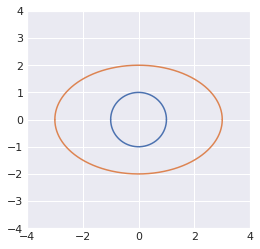

In [8]:
x1 = np.linspace(-3, 3, 100000)
y1 = 2 * np.sqrt(1 - ((x1 / 3) ** 2))

plt.plot(x, y, sns.color_palette().as_hex()[0])
plt.plot(x, -y, sns.color_palette().as_hex()[0])
plt.plot(x1, y1, sns.color_palette().as_hex()[1])
plt.plot(x1, -y1, sns.color_palette().as_hex()[1])
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

This shows that our transformation was correct.

Note that these examples used **diagonal matrices** (all zeros except the diagonal). The general rule is that the transformation associated with diagonal matrices imply only a rescaling of each coordinate **without rotation**. This is a first element to understand the SVD. Look again at the decomposition

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/singular-value-decomposition.png?raw=1" width="300">

> The transformation associated with diagonal matrices imply only a rescaling of each coordinate **without rotation**.

We saw that the matrix ${D}$ is a diagonal matrix. And we saw also that it corresponds to a rescaling without rotation.

### Example 4: Rotation matrix

Matrices that are not diagonal can produce a rotation (see more details [here](https://en.wikipedia.org/wiki/Rotation_matrix)). Since it is easier to think about angles when we talk about rotation, we will use a matrix of the form

$$
R=
\begin{bmatrix}
    cos(\theta) & -sin(\theta)\\\\
    sin(\theta) & cos(\theta)
\end{bmatrix}
$$

This matrix will rotate our vectors or matrices counterclockwise through an angle $\theta$. Our new coordinates will be

$$
\begin{bmatrix}
    x'\\\\
    y'
\end{bmatrix}=
\begin{bmatrix}
    cos(\theta) & -sin(\theta)\\\\
    sin(\theta) & cos(\theta)
\end{bmatrix}
\begin{bmatrix}
    x\\\\
    y
\end{bmatrix}=
\begin{bmatrix}
    xcos(\theta) - ysin(\theta)\\\\
    xsin(\theta) + ycos(\theta)
\end{bmatrix}
$$

Let's rotate some vectors through an angle of $\theta = 45^\circ$.

$$
R=
\begin{bmatrix}
    cos(45) & -sin(45)\\\\
    sin(45) & cos(45)
\end{bmatrix}
= \begin{bmatrix}
    0.70 & -0.70\\\\
    0.70 & 0.70
\end{bmatrix}
$$


Let's start with the vector ${u}$ of coordinates $x=0$ and $y=1$ and the vector ${v}$ of coordinates $x=1$ and $y=0$. The vectors ${u'}$ ${v'}$ are the rotated vectors.

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/unit-vectors-rotation.png?raw=1" width="200" alt="Rotation of the unit vectors through matrix operation" title="Rotation of the unit vectors">

<em>Counter clockwise rotation of the unit vectors with $\theta = 45^\circ$</em>

First, let's plot ${u}$ and ${v}$.

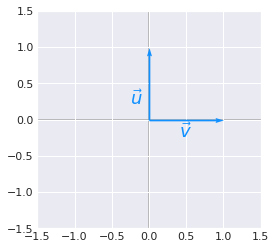

In [9]:
orange = '#FF9A13'
blue = '#1190FF'

u = [1, 0]
v = [0, 1]

plot_vectors([u, v], cols=[blue, blue])

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

plt.text(-0.25, 0.2, r'$\vec{u}$', color=blue, size=18)
plt.text(0.4, -0.25, r'$\vec{v}$', color=blue, size=18)
plt.show()

They are the <a href="https://en.wikipedia.org/wiki/Basis_(linear_algebra)">basis vectors</a> of our space. We will calculate the transformation of these vectors:

$$
\begin{cases}
u_x = 0\cdot cos(45) - 1\cdot sin(45)\\\\
u_y = 0\cdot sin(45) + 1\cdot cos(45)
\end{cases}
\Leftrightarrow
\begin{cases}
u_x = -sin(45)\\\\
u_y = cos(45)
\end{cases}
$$

$$
\begin{cases}
v_x = 1\cdot cos(45) - 0\cdot sin(45)\\\\
v_y = 1\cdot sin(45) + 0\cdot cos(45)
\end{cases}
\Leftrightarrow
\begin{cases}
v_x = cos(45)\\\\
v_y = sin(45)
\end{cases}
$$

We will now plot these new vectors to check that they are well our basis vectors rotated through an angle of $45^\circ$.

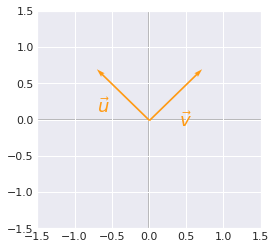

In [10]:
u1 = [-np.sin(np.radians(45)), np.cos(np.radians(45))]
v1 = [np.cos(np.radians(45)), np.sin(np.radians(45))]

plot_vectors([u1, v1], cols=[orange, orange])

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

plt.text(-0.7, 0.1, r'$\vec{u}$', color=orange, size=18)
plt.text(0.4, -0.1, r'$\vec{v}$', color=orange, size=18)
plt.show()

**Coding tip:** the numpy functions `sin` and `cos` take input in radians. We can convert our angle from degrees to radians with the function `np.radians()`.

We can also transform a circle. We will take a rescaled circle (the one from the example 3.) to be able to see the effect of the rotation.

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/rescaled-circle-rotated.png?raw=1" width="300" alt="A rescaled circle (not the same hight and width) rotated" title="Rescaled circle rotated">

<em>The effect of a rotation matrix on a rescaled circle</em>

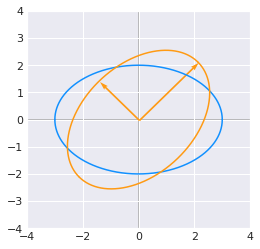

In [11]:
x = np.linspace(-3, 3, 100000)
y = 2 * np.sqrt(1 - ((x / 3) ** 2))

x1 = x * np.cos(np.radians(45)) - y * np.sin(np.radians(45))
y1 = x * np.sin(np.radians(45)) + y * np.cos(np.radians(45))

x1_neg = x * np.cos(np.radians(45)) - -y * np.sin(np.radians(45))
y1_neg = x * np.sin(np.radians(45)) + -y * np.cos(np.radians(45))

u1 = [-2 * np.cos(np.radians(45)), 2 * np.sin(np.radians(45))]
v1 = [3 * np.sin(np.radians(45)), 3 * np.cos(np.radians(45))]

plot_vectors([u1, v1], cols=["#FF9A13", "#FF9A13"])

plt.plot(x, y, '#1190FF')
plt.plot(x, -y, '#1190FF')

plt.plot(x1, y1, '#FF9A13')
plt.plot(x1_neg, y1_neg, '#FF9A13')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

We can see that the circle has been rotated by an angle of $45^\circ$. We have chosen the length of the vectors from the rescaling weight from example 3 (factor 3 and 2) to match the circle.

### Summary

I hope that you got how vectors and matrices can be transformed by rotating or scaling matrices. 

**The SVD can be seen as the decomposition of one complex transformation in 3 simpler transformations**:

1. a rotation, 
2. a scaling and 
3. another rotation

Note that we took only square matrices. The SVD can be done even with non square matrices but it is harder to represent transformation associated with non square matrices. For instance, a 3 by 2 matrix will map a 2D space to a 3D space.

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/non-square-matrix-change-dimensions.png?raw=1" width="250" alt="A non square matrix change the number of dimensions of the input" title="Example of a change of dimensions">

<em>A non square matrix change the number of dimensions of the input</em>

## The three transformations

We can use `plot_matrix` to check that the three transformations given by the SVD are equivalent to the transformation done with the original matrix. We will also draw each step of the SVD to see the independant effect of the first rotation, the scaling and the second rotation.

We will use the matrix:

$$
{A}=\begin{bmatrix}
    3 & 7\\\\
    5 & 2
\end{bmatrix}
$$

and plot the unit circle and its transformation by ${A}$:

Unit circle:


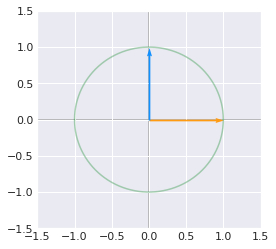

Unit circle transformed by A:


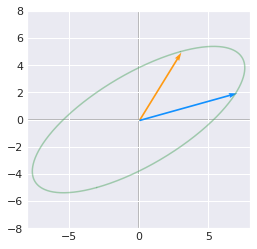

In [12]:
A = np.array([
  [3, 7],
  [5, 2]
])

print("Unit circle:")
plot_matrix(np.array([[1, 0], [0, 1]]))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

print("Unit circle transformed by A:")
plot_matrix(A)
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

This is what we get when we apply the matrix ${A}$ to the unit circle and the basis vectors. We can see that the two base vectors are not necessarily rotated the same way. This is related to the sign of the determinant of the matrix (see [2.11](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.11-The-determinant/)).

Let's now compute the SVD of ${A}$:

In [13]:
U, D, V = np.linalg.svd(A)
U

array([[-0.85065081, -0.52573111],
       [-0.52573111,  0.85065081]])

In [14]:
D

array([8.71337969, 3.32821489])

In [15]:
V

array([[-0.59455781, -0.80405286],
       [ 0.80405286, -0.59455781]])

We can now look at the sub-transformations by looking at the effect of the matrices ${U}$, ${D}$ and ${V}$ in the reverse order. 

Note that it returns the right singular vector **already transposed** (see the [doc](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html)).

Unit circle:


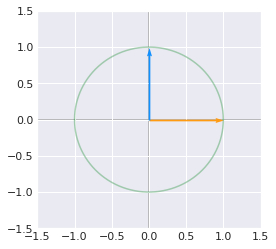

First rotation:


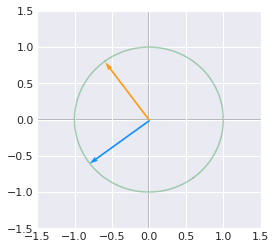

Scaling:


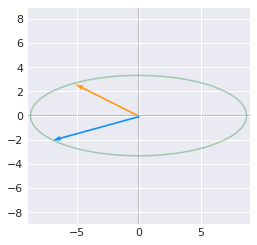

Second rotation:


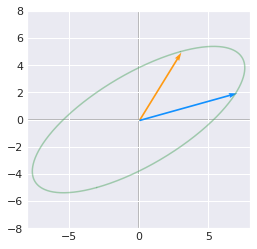

In [16]:
print("Unit circle:")
plot_matrix(np.array([[1, 0], [0, 1]]))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

print("First rotation:")
plot_matrix(V)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

print("Scaling:")
plot_matrix(np.diag(D).dot(V))
plt.xlim(-9, 9)
plt.ylim(-9, 9)
plt.show()

print("Second rotation:")
plot_matrix(U.dot(np.diag(D)).dot(V))
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

Just to be sure, you can compare this last step with the transformation by ${A}$. 

Fortunately, you will see that the result is the same:

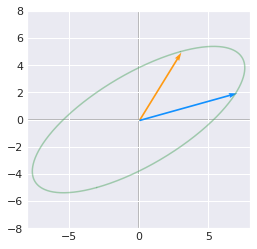

In [17]:
plot_matrix(A)
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

##Singular values interpretation

The singular values are ordered by descending order. They correspond to a new set of features (that are a linear combination of the original features) with the first feature explaining most of the variance. 

For instance from the last example we can visualize these new features. The major axis of the elipse will be the first left singular vector ($u_1$) and its norm will be the first singular value ($\sigma_1$).

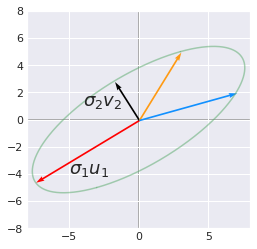

In [18]:
u1 = [D[0] * U[0, 0], D[0] * U[0, 1]]
v1 = [D[1] * U[1, 0], D[1] * U[1, 1]]

plot_vectors([u1, v1], cols=["red", "black"])

plot_matrix(A)

plt.text(-5, -4, r"$\sigma_1u_1$", size=18)
plt.text(-4, 1, r"$\sigma_2v_2$", size=18)

plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

They are the major ($\sigma_1u_1$) and minor ($\sigma_2u_2$) axes of the elipse. We can see that the feature corresponding to this major axis is associated with more variance (the range of value on this axis is bigger than the other). 

See [2.12](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.12-Example-Principal-Components-Analysis/) for more details about the variance explained.

##SVD and eigendecomposition

Now that we understand the kind of decomposition done with the SVD, we want to know how the sub-transformations are found.

The matrices ${U}$, ${D}$ and ${V}$ can be found by transforming ${A}$ in a square matrix and by computing the eigenvectors of this square matrix. The square matrix can be obtain by multiplying the matrix ${A}$ by its transpose in one way or the other:

- ${U}$ corresponds to the eigenvectors of ${AA}^\text{T}$
- ${V}$ corresponds to the eigenvectors of ${A^\text{T}A}$
- ${D}$ corresponds to the eigenvalues ${AA}^\text{T}$ or ${A^\text{T}A}$ which are the same.

Let's take an example of a non square matrix:

$$
{A}=\begin{bmatrix}
    7 & 2\\\\
    3 & 4\\\\
    5 & 3
\end{bmatrix}
$$

The singular value decomposition can be done with the `linalg.svd()` function from Numpy (note that `np.linalg.eig(A)` works only on square matrices and will give an error for `A`).

In [19]:
A = np.array([
  [7, 2],
  [3, 4],
  [5, 3]
])

U, D, V = np.linalg.svd(A)
U

array([[-0.69366543,  0.59343205, -0.40824829],
       [-0.4427092 , -0.79833696, -0.40824829],
       [-0.56818732, -0.10245245,  0.81649658]])

In [20]:
D

array([10.25142677,  2.62835484])

In [22]:
V

array([[-0.88033817, -0.47434662],
       [ 0.47434662, -0.88033817]])

### Example 5: The left-singular values

The left-singular values of ${A}$ correspond to the eigenvectors of ${AA}^\text{T}$.

Note that the sign difference comes from the fact that eigenvectors are not unique. The `linalg` functions from Numpy return the normalized eigenvectors. Scaling by `-1` doesn't change their direction or the fact that they are unit vectors.

In [23]:
U, D, V = np.linalg.svd(A)

Left singular vectors of A:

In [24]:
U

array([[-0.69366543,  0.59343205, -0.40824829],
       [-0.4427092 , -0.79833696, -0.40824829],
       [-0.56818732, -0.10245245,  0.81649658]])

Eigenvectors of AA_transpose:

In [25]:
np.linalg.eig(A.dot(A.T))[1]

array([[-0.69366543, -0.59343205, -0.40824829],
       [-0.4427092 ,  0.79833696, -0.40824829],
       [-0.56818732,  0.10245245,  0.81649658]])

### Example 6: The right-singular values

The right-singular values of ${A}$ correspond to the eigenvectors of ${A}^\text{T}{A}$.

In [26]:
U, D, V = np.linalg.svd(A)

Right singular vectors of A:

In [27]:
V

array([[-0.88033817, -0.47434662],
       [ 0.47434662, -0.88033817]])

Eigenvectors of $A^TA$:

In [28]:
np.linalg.eig(A.T.dot(A))[1]

array([[ 0.88033817, -0.47434662],
       [ 0.47434662,  0.88033817]])

### Example 7: The nonzero singular values

The nonzero singular values of ${A}$ are the square roots of the eigenvalues of ${A}^\text{T}{A}$ and ${AA}^\text{T}$.

In [30]:
U, D, V = np.linalg.svd(A)
D

array([10.25142677,  2.62835484])

Eigenvalues of $A^TA$:

In [34]:
np.linalg.eig(A.T.dot(A))[0]

array([105.09175083,   6.90824917])

Eigenvalues of $AA^T$:

In [35]:
np.linalg.eig(A.dot(A.T))[0]

array([105.09175083,   6.90824917,  -0.        ])

Square root of the eigenvalues:

In [36]:
np.sqrt(np.linalg.eig(A.T.dot(A))[0])

array([10.25142677,  2.62835484])

## BONUS: Apply the SVD on images

In this example, we will use the SVD to extract the more important features from the image. It is nice to see the effect of the SVD on something very visual. The code is inspired/taken from [this blog post](https://www.frankcleary.com/svdimage/).

Let's start by loading an image in python and convert it to a Numpy array. We will convert it to grayscale to have one dimension per pixel. The shape of the matrix corresponds to the dimension of the image filled with intensity values: 1 cell per pixel.

## References

**Drawing a circle with Matplotlib**

1.   List item
2.   List item



- https://stackoverflow.com/questions/32092899/plot-equation-showing-a-circle

**Rotation matrix**

- https://en.wikipedia.org/wiki/Rotation_matrix)

**Basis vectors**

- https://en.wikipedia.org/wiki/Basis_(linear_algebra)

**Linear transformation**

- [Aran Glancy - Linear transformation and matrices](https://www.youtube.com/watch?v=kJIUbtSowRg)

**SVD**

- [Singular Value Decomposition - Wikipedia](https://en.wikipedia.org/wiki/Singular-value_decomposition)

- [Professor-svd](https://fr.mathworks.com/company/newsletters/articles/professor-svd.html)

- [Intoli - PCA and SVD](https://intoli.com/blog/pca-and-svd/)

**Numpy**

- [Numpy SVD doc](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html)

**Image processing**

- [Frank Cleary - SVD of an image](https://www.frankcleary.com/svdimage/)